In [2]:
googlecolab = True

if googlecolab:
    from os.path import exists
    from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
    platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
    cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
    accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

    !pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision
    !pip install Pillow==4.1.1

tcmalloc: large alloc 1073750016 bytes == 0x58aec000 @  0x7f0cf03502a4 0x591a07 0x5b5d56 0x502e9a 0x506859 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x504c28 0x502540 0x502f3d 0x507641
    100% |████████████████████████████████| 5.7MB 7.0MB/s 
  Found existing installation: Pillow 5.3.0
    Uninstalling Pillow-5.3.0:
      Successfully uninstalled Pillow-5.3.0


In [0]:
%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

## Hyperpameters

Define the hyperparameters. You can play with those later.

In [4]:
## Data loading

workers = 0 # Number of workers for dataloader (/!\ set to 4 when you're done debugging)

## Architecture

nz = 100 # Size of z latent vector (i.e. size of generator input)
ndf = 32 # Base size of feature maps in discriminator
ngf = 32 # Base size of feature maps in generator

## Optimization

lrD = 0.0002 # Learning rate for the discriminator
lrG = 0.0002 # Learning rate for the generator
beta1G = 0.5 # Momentum beta1 for the discriminator
beta1D = 0.5 # Momentum beta1 for the generator

## Training

batch_size = 256 # Images per batch
nb_update_D = 1 # Number of sub-steps of discriminator optim. at each step
nb_update_G = 1 # Number of sub-steps of generator optim. at each step
steps = 8000 # Number of global steps in the training loop
nb_epochs = None # Number of epochs, leave "None" if you want to set the number of "steps" (i.e. batches)


if nb_epochs is None:
    nb_epochs = (steps * batch_size) / (nb_update_D * 202000)
else:
    steps = int(nb_epochs * nb_update_D * 202000 / batch_size)
print("Doing %.1f epochs in %d steps" % (nb_epochs, steps))

Doing 10.1 epochs in 8000 steps


# Dataset

Download and load the dataset. Nothing to do here.

In [5]:
%%sh
# Dataset loading

if ! [ -d "/tmp/celeba/img_align_celeba" ] ; then
    mkdir /tmp/celeba
    cd /tmp/celeba
    wget http://webia.lip6.fr/~robert/cours/rdfia/celeba.zip
    unzip celeba.zip
fi

# For 64x64 images, replace celeba with celeba64 everywhere

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

--2018-12-19 15:06:55--  http://webia.lip6.fr/~robert/cours/rdfia/celeba.zip
Resolving webia.lip6.fr (webia.lip6.fr)... 132.227.201.33
Connecting to webia.lip6.fr (webia.lip6.fr)|132.227.201.33|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 153357646 (146M) [application/zip]
Saving to: ‘celeba.zip’

     0K .......... .......... .......... .......... ..........  0% 97.1K 25m42s
    50K .......... .......... .......... .......... ..........  0%  194K 19m16s
   100K .......... .......... .......... .......... ..........  0% 86.7M 12m51s
   150K .......... .......... .......... .......... ..........  0% 87.6M 9m39s
   200K .......... .......

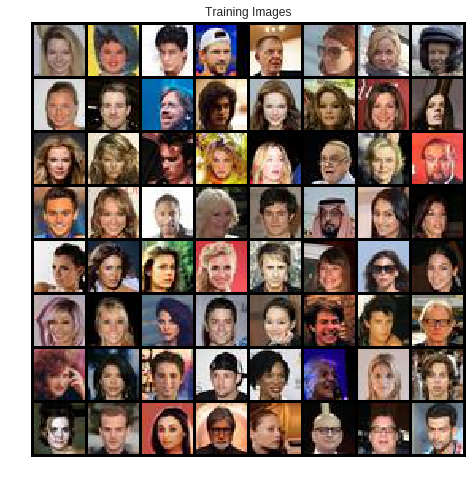

In [6]:
# We can use an image folder dataset the way we have it setup.
# Create the dataset
dataset = dset.ImageFolder(root="/tmp/celeba",
                           transform=transforms.Compose([
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))
# Create the dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

# Decide which device we want to run on
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))
plt.show()

# Model architectures

## Discriminator

Input: Image $x \in \mathbb{R}^{32\times 32\times 3}$  
Output: "Real" image probability $\in [0,1]$

* Convolution (`1*ndf` filters, kernel 4, stride 2, padding 1, no bias)
* Batch Norm 2D
* LeakyReLU ($\alpha = 0.2$)
* Convolution (`2*ndf` filters, kernel 4, stride 2, padding 1, no bias)
* Batch Norm 2D
* LeakyReLU ($\alpha = 0.2$)
* Convolution (`4*ndf` filters, kernel 4, stride 2, padding 1, no bias)
* Batch Norm 2D
* LeakyReLU ($\alpha = 0.2$)
* Convolution (1 filter, kernel 4, stride 1, padding 0, no bias)
* Sigmoid activation

## Generator

Input: Random "noise" $z \in \mathbb{R}^{\text{nz}}$  
Output: Generated image $\tilde x \in \mathbb{R}^{32\times 32\times 3}$

* Convolution Transpose (`4*ngf` filters, kernel 4, stride 1, padding 0, no bias)
* Batch Norm 2D
* ReLU
* Convolution Transpose (`2*ngf` filters, kernel 4, stride 2, padding 1, no bias)
* Batch Norm 2D
* ReLU
* Convolution Transpose (`1*ngf` filters, kernel 4, stride 2, padding 1, no bias)
* Batch Norm 2D
* ReLU
* Convolution Transpose (3 filters, kernel 4, stride 2, padding 1, no bias)
* Tanh activation

In [0]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, ndf, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(ndf),
            nn.LeakyReLU(0.2),
            nn.Conv2d(ndf, 2*ndf, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(2*ndf),
            nn.LeakyReLU(0.2),
            nn.Conv2d(2*ndf, 4*ndf, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(4*ndf),
            nn.LeakyReLU(0.2),
            nn.Conv2d(4*ndf, 1, kernel_size=4, stride=1, padding=0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.model(input)


class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.ConvTranspose2d(nz, 4*ngf, kernel_size=4, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(4*ngf),
            nn.ReLU(),
            nn.ConvTranspose2d(4*ngf, 2*ngf, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(2*ngf),
            nn.ReLU(),
            nn.ConvTranspose2d(2*ngf, ngf, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(),
            nn.ConvTranspose2d(ngf, 3, kernel_size=4, stride=2, padding=1, bias=False),
            nn.Tanh()
        )

    def forward(self, input):
        return self.model(input)

In [8]:
# Create the models
netG = Generator().to(device)
netD = Discriminator().to(device)

# Apply the weights_init function to randomly initialize all weights to mean=0, stdev=0.2
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)
netG.apply(weights_init)
netD.apply(weights_init)

# Print the models
print(netG)
print(netD)

Generator(
  (model): Sequential(
    (0): ConvTranspose2d(100, 128, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): ConvTranspose2d(32, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): Tanh()
  )
)
Discriminator(
  (model): Sequential(
    (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
    (

In [9]:
z = torch.zeros(10, nz, 1, 1).to(device)
x = torch.zeros(10, 3, 32, 32).to(device)
print(netG(z).shape) # expected: [10, 3, 32, 32]
print(netD(x).shape) # expected: [10, 1, 1, 1]

torch.Size([10, 3, 32, 32])
torch.Size([10, 1, 1, 1])


# Optimization and training

Here we will define:
* Our prior $P(z)$ that we use to sample random "noise". We will use a Gaussian distribution.
* The criterion that will be used to train the discriminator, and indirectly the generator. We will use the binary cross-entropy.
* The optimizers of both models. We will use the Adam optimizer.

In [0]:
# Prior P(z). Returns a Gaussian random tensor of shape (batch_size, nz, 1, 1)
def get_noise(batch_size):
    noise = torch.randn((batch_size, nz, 1, 1))
    return noise.to(device)

# Create the criterion function that will take (y_hat, y) as input
criterion = torch.nn.BCELoss()

# Setup Adam optimizers for D and G
optimizerD = torch.optim.Adam(netD.parameters(), lr=lrD, betas=(beta1D, 0.999)) #take netD.parameters(), use the right lr and beta1
optimizerG = torch.optim.Adam(netG.parameters(), lr=lrG, betas=(beta1G, 0.999)) #same for G

### Data format / batch creation functions

In [0]:
# Data format / batch creation functions

fixed_noise = get_noise(196) # Create a fixed random vector sampled from a Gaussian, will be used during train for viz
real_label = 1
fake_label = 0
iterator = iter(dataloader)

# returns a batch of real images from the dataset (iterates infinitely on the dataset)
def get_batch_real():
    global iterator
    try:
        x_real = next(iterator)[0].to(device)
    except:
        iterator = iter(dataloader)
        x_real = next(iterator)[0].to(device)
    y_real = torch.full((x_real.size(0),), real_label, device=device)
    return x_real, y_real

# returns a batch of generated images and training targets y_fake
# Note that the targets y_fake will be different is train_G is True or False
def get_batch_fake(train_G=False):
    z = get_noise(batch_size)
    x_fake = netG(z) # generate images from z
    label = real_label if train_G else fake_label
    y_fake = torch.full((x_fake.size(0),), label, device=device) # create targets, depends on train_G
    return x_fake, y_fake

### Training Loop

**Reminder:** when your training loop starts to work, change the `workers` variable to 4 and rerun your notebook

In [0]:
img_list = []
G_losses = []
D_losses = []

In [0]:
for i in range(steps):
    
    ########
    # Update D network: maximize log(D(x)) + log(1 - D(G(z)))
    for _ in range(nb_update_D):
        netD.zero_grad()
        
        # Create batches
        x_real, y_real = get_batch_real()
        x_fake, y_fake = get_batch_fake()
        
        # Forward 
        y_hat_real = netD(x_real)
        y_hat_fake = netD(x_fake.detach())
        errD = criterion(y_hat_real, y_real) + criterion(y_hat_fake, y_fake) # sum of criterion of real and fake samples
        
        # Backward
        # backward & optimization step on D
        errD.backward()
        optimizerD.step()
        # Compute / save metrics
        avg_output_for_real = y_hat_real.mean().item()
        avg_output_for_fake = y_hat_fake.mean().item()    
        D_losses.append(errD.item())



    ########
    # Update G network: maximize log(D(G(z)))
    for _ in range(nb_update_G):
        netG.zero_grad()
        
        # forward + backward
        # NOTE: use errG as name for your loss variable, like errD above
        # Create batches
        x_real, y_real = get_batch_real()
        x_fake, y_fake = get_batch_fake(train_G=True)
        
        # Forward 
        y_hat_real = netD(x_real)
        y_hat_fake = netD(x_fake)
        errG = criterion(y_hat_fake, y_fake) # sum of criterion of real and fake samples
        
        # Backward
        # backward & optimization step on D
        errG.backward()
        optimizerG.step()
        # Compute / save metrics
        G_losses.append(errG.item())
        
    
    ########
    # Logs
    if i % 25 == 0:
        print('[%5d/%5d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f'
              % (i, steps, errD.item(), errG.item(), avg_output_for_real, avg_output_for_fake))

    if i % 100 == 0:
        with torch.no_grad():
            x_fake = netG(fixed_noise).detach().cpu()
        img_list.append(vutils.make_grid(x_fake, padding=2, normalize=True, nrow=14))
        plt.figure(figsize=(8,8))
        plt.imshow(np.transpose(img_list[-1],(1,2,0)))
        plt.axis("off")
        plt.show()
        

# Display training evolution

In [0]:
# Show generations
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

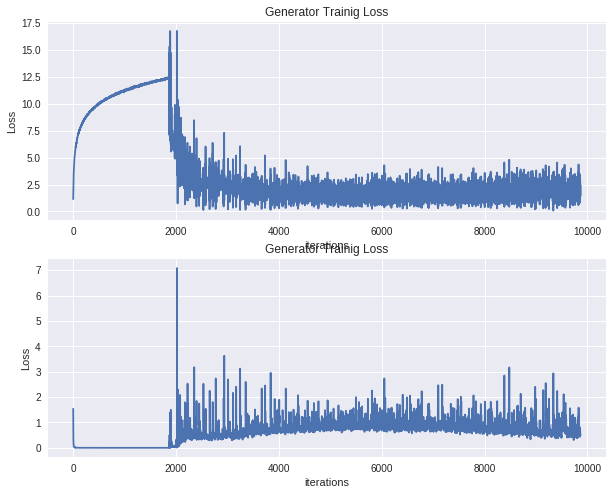

In [17]:
# Loss evolution
plt.figure(figsize=(10,8))
plt.subplot(2,1,1)
plt.title("Generator Trainig Loss")
plt.plot(G_losses)
plt.xlabel("iterations")
plt.ylabel("Loss")

plt.subplot(2,1,2)
plt.title("Generator Trainig Loss")
plt.plot(D_losses)
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.show()